In [ ]:
# default_exp patrones_espacio_temporales

In [ ]:
# export
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from criminologia_cdmx.etl import *
from functools import partial

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# patrones_espacio_temporales

> Métodos para explorar los patrones espacio-temporales de la delincuencia y su evolución

* Hotspots con KDE
* Significancia de hotspots (https://doi.org/10.1080/13658816.2017.1406943)


## kde2D

## construye_malla

In [ ]:
# export
def construye_malla(datos, size):
    """ Regresa una malla (np.meshgrid) ajustada al extent de los datos, 
        con el tamaño de celda especificado.
        
        Args:
            datos (GeoDataFrame): carpetas o víctimas
            size (float): tamaño de las celdas (en las unidades de la proyección)
        
    """
    xmin, ymin, xmax, ymax = datos.geometry.total_bounds
    xgrid = np.arange(xmin, xmax, size)
    ygrid = np.arange(ymin, ymax, size)
    X, Y = np.meshgrid(xgrid, ygrid)
    return (X, Y)

In [ ]:
carpetas = get_carpetas_from_api(10000)
carpetas = carpetas.to_crs(32614)
malla = construye_malla(carpetas, 200)

## ajusta_bandwidth_kde

In [ ]:
# exports
def ajusta_bandwidth_kde(datos, bandwidth_space, size=1000, 
                         malla=None, n_jobs=-1, metric="euclidean"):
    """ Regresa el valor de bandwidth con mejor log likelihood.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith_space (np.linspace):  con el espacio de búsqueda
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
            n_jobs (int): número de procesos a usar (default = -1)
            metric (str): métrica a usar para calcular las distancias (default euclidean)
    """
    if malla is None:
        xx, yy = construye_malla(datos, size)
    else:
        xx = malla[0]
        yy = malla[1]        
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    xy_train  = np.vstack([y, x]).T
    grid = GridSearchCV(KernelDensity(metric=metric), bandwidth_space, n_jobs=n_jobs)
    grid.fit(xy_train)
    return grid.best_estimator_.bandwidth

Esta función ajusta el ancho de banda para calcular un KDE en 2 dimensiones. Puede ser muy tardado.

El ancho de banda se puede calcular en cualquyier sistema de coordenadas, sin embargo es conveniente proyectarlos a coordenadas planas.

Primero ajustamos especificando el tamaño de la malla

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, size=1000)
print(bw)

312.72727272727275


También podemos especificar la malla primero

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, malla=malla)
print(bw)

312.72727272727275


## kde2D

Regresa la superficie del KDE con los parámetros especificados

In [ ]:
# export

def kde2D(datos, bandwidth, size=1000, malla=None):
    """ Regresa una matriz con la densidad de kernel para los datos.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith: ancho del kernel gaussiano
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            metric (str): métrica a usar para calcular las distancias (default euclidean)
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
    """    
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    if malla is None:
        X, Y = construye_malla(datos, size)
    else:
        X = malla[0]
        Y = malla[1]
    XY = np.vstack([Y.ravel(), X.ravel()]).T
    xy_train = np.vstack([y, x]).T
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(xy_train)
    # Z = kde.score_samples(XY)
    Z = np.exp(kde.score_samples(XY))
    return X, Y, np.reshape(Z, X.shape)

Si no mandamos una malla como argumento, se calcula utilizando `size`

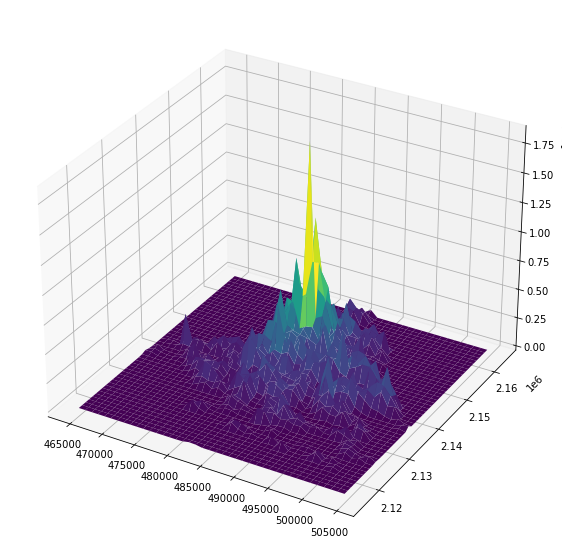

In [ ]:
xx, yy, zz = kde2D(carpetas, bw, size=1000)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

También se puede especificar una malla con el tamaño deseado y calcular el KDE

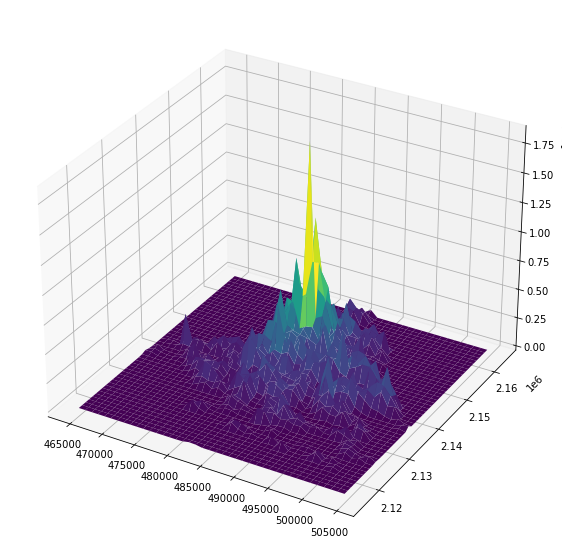

In [ ]:
malla = construye_malla(carpetas, 1000)
xx, yy, zz = kde2D(carpetas, bw, malla=malla)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

## malla_comun

In [ ]:
def malla_comun(datos, size):
    """ Regresa la malla más pequeña (de tamaño size) que contiene a todos los datos.
    
        Args:
            datos(list(GeoDataGrames)): lista con los datos para la malla común.
            size (float): tamaño de las celdas en la malla.
    """
    envolventes = [d.geometry.unary_union.envelope for d in datos]
    envolventes = gpd.GeoSeries(envolventes)
    xmin, ymin, xmax, ymax = envolventes.unary_union.envelope.bounds
    xgrid = np.arange(xmin, xmax, size)
    ygrid = np.arange(ymin, ymax, size)
    X, Y = np.meshgrid(xgrid, ygrid)
    return (X, Y)

Esta función se usa dentro de `serie_tiempo_kde_categoria` y no se llama directamente.

## get_lista_datos

In [ ]:
# export
def get_lista_datos(carpetas, fechas, categorias, offset):
    """ Regresa una lista de GeoDataFrames con los datos segmentados en fechas 
        para la categoría seleccionada.
        
    """
    fecha_inicio = fechas[0] - pd.to_timedelta(offset)
    fechas.insert(0, fecha_inicio)
    intervalos = [(fechas[i-1], f) for i, f in enumerate(fechas[1:],1)]
    datos = []
    for intervalo in intervalos:
        datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(*intervalo, inclusive='left')) &
                                       (carpetas['categoria'].isin(categorias))]
        datos.append(datos_intervalo)
    return datos 

In [ ]:
carpetas = get_historico_carpetas()
carpetas = agregar_categorias_carpetas(carpetas)
carpetas = carpetas.to_crs(32614)
fechas = pd.date_range(start='1/1/2020', end='3/1/2020', freq='M').to_list()
categorias = ["Homicidios dolosos"]
datos = get_lista_datos(carpetas, fechas, categorias, "30 days")
datos[0].head()

,ao_hechos,mes_hechos,fecha_hechos,ao_inicio,mes_inicio,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,...,calle_hechos,calle_hechos2,colonia_hechos,alcaldia_hechos,competencia,longitud,latitud,tempo,geometry,categoria
895799,2020.0,Enero,2020-01-01 04:50:00,2020,Enero,2020-01-01 05:59:10,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,15 Y AVENIDA GUADALUPE,NaN,GUADALUPE PROLETARIA,GUSTAVO A MADERO,NaN,-99.156937,19.521753,NaN,POINT (483534.561 2158567.439),Homicidios dolosos
895810,2020.0,Enero,2020-01-01 07:30:00,2020,Enero,2020-01-01 08:43:13,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,PIRULES,NaN,TLALPEXCO,GUSTAVO A MADERO,NaN,-99.128763,19.544280,NaN,POINT (486492.381 2161057.661),Homicidios dolosos
895835,2020.0,Enero,2020-01-01 11:00:00,2020,Enero,2020-01-01 11:04:10,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN TERRITORIAL EN IZTAP...,IZP-9,UI-3SD,...,elisa,NaN,2A. AMPLIACIÓN SANTIAGO ACAHUALTEPEC,IZTAPALAPA,NaN,-99.015140,19.347795,NaN,POINT (498409.849 2139310.995),Homicidios dolosos
895836,2020.0,Enero,2020-01-01 09:55:00,2020,Enero,2020-01-01 11:05:21,HOMICIDIO POR ARMA BLANCA,FISCALÍA DE INVESTIGACIÓN TERRITORIAL EN MIGUE...,H1,UI-1SD,...,F.C. NACIONALES DE MEXICO,AND. NUEVA GALICIA,NUEVA ESPAÑA,AZCAPOTZALCO,NaN,-99.189655,19.498750,NaN,POINT (480099.007 2156025.577),Homicidios dolosos
896408,2020.0,Enero,2020-01-02 19:20:00,2020,Enero,2020-01-02 19:53:43,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,25 DE SEPTIEMBRE DE 1873,PUENTE QUEMADO,LEYES DE REFORMA 3A SECCIÓN,IZTAPALAPA,NaN,-99.061941,19.376333,NaN,POINT (493495.517 2142469.932),Homicidios dolosos


## serie_tiempo_kde_categoria

In [ ]:
# export
def serie_tiempo_kde_categoria(datos, size,
                               malla = None,
                               grid_search={'bandwidth': np.linspace(10, 10000, 100)},
                               bw=None):
    """ Ajusta kdes egregando los datos sobre cada categoria e intervalo de fecha.

       Args:
           datos list(GeoDataFrame): Lista con los datos para cada intervalo a procesar
           categorias: Lista de categorías para calcular el KDE
           offset: intervalo para agregar antes de la primera fecha, p.ej: "30 days" si los intervalos son mensuales
           size (float): Tamaño de la celda (en las unidades de la proyección)
           grid_search: {'bandwidth': np.linspace(0.001, 0.1, 100)} valores para ajustar el bandwidth (se usa sólo si bandwidth es nulo)
           bandwidth: Si no se especifica grid_search, se tiene que dar un valor de bandwidth
           **kwargs: argumentos extra que se pasan a `kde2D`

       returns:
       (xx, yy) [zz]: la tupla (xx, yy) es el grid común de los kdes, la lista contiene los valores de z para cada intervalo
    """
    if malla is None:
        malla = malla_comun(datos, size)
    if bw is None:
        bw = ajusta_bandwidth_kde(datos_intervalo, size, grid_search)
    kde2D_p = lambda d: kde2D(d, bw, size=size, malla=malla) 
    kdes = map(kde2D_p, datos)
    kdes = [k[2] for k in kdes]
    return malla[0], malla[1], kdes

In [ ]:
xx, yy, kdes = serie_tiempo_kde_categoria(datos, 500, bw=300)
assert type(kdes[0]) == np.ndarray

Podemos inspeccionar rápidamete cualquiera de los KDEs obtenidos

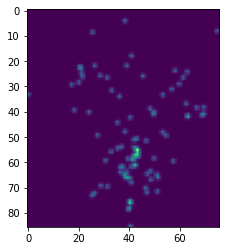

In [ ]:
plt.imshow(kdes[1])

## serie_razones_de_eventos

In [ ]:
# export
def serie_razones_de_eventos(carpetas, fechas, categoria, offset, size, bw):
    """Regresa el mapa de razón entre una categoría con respecto a las demás."""
    datos_categoria = get_lista_datos(carpetas, fechas, categoria, offset)
    categorias_todas = list(carpetas[carpetas.categoria.notnull()]['categoria'].unique())
    categorias_todas = set(categorias_todas) - set(categoria)
    datos_base = get_lista_datos(carpetas, fechas, categorias_todas, offset)
    datos_completos = datos_categoria + datos_base
    malla = malla_comun(datos_completos, size)
    _, _, kdes_categoria = serie_tiempo_kde_categoria(datos_categoria, size, bw=bw, malla=malla)
    _, _, kdes_base = serie_tiempo_kde_categoria(datos_base, size, bw=bw, malla=malla)
    # TODO: vectorizar esta operación np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    sr = [e / b for e,b in zip(kdes_categoria, kdes_base)]
    return malla[0], malla[1], sr

Calculamos la serie de mapas de razones

In [ ]:
xx, yy, serie_razones = serie_razones_de_eventos(carpetas, 
                                         fechas, 
                                         ["Homicidios dolosos"], 
                                         "30 days", 
                                         2500,
                                         2500)

La podemos visualizar usando superficies

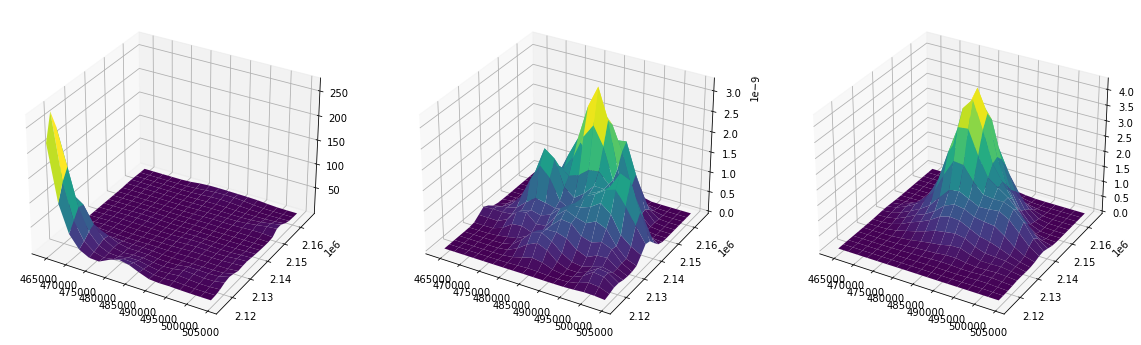

In [ ]:
fig = plt.figure(figsize=(20,40))
ax = fig.add_subplot(131, projection='3d')
ax = ax.plot_surface(xx, yy, razon_n,cmap='viridis', edgecolor='none')
ax = fig.add_subplot(132, projection='3d')
ax = ax.plot_surface(xx, yy, kdes_categoria[0],cmap='viridis', edgecolor='none')
ax = fig.add_subplot(133, projection='3d')
ax = ax.plot_surface(xx, yy, kdes_base[0],cmap='viridis', edgecolor='none')

## serie_mapas_intensidad

In [ ]:
# export
def serie_mapas_intensidad(carpetas, fechas, categorias, offset, size, bw):
    """Regresa los mapas de razon y las intensidades de la categoría para las `fechas` seleccionadas."""
    xx, yy, razones = serie_razones_de_eventos(carpetas, fechas, categorias,
                                               offset, size, bw)
    avg = np.mean(razones, axis=0)
    std = np.std(razones, axis=0)
    intensidad = [(r - avg) / std for r in razones]
    p_values = []
    for r in razones:
        comp = [b >= r for b in razones]
        comp = np.sum(comp, axis=0)
        p = comp / (len(razones) + 1)
        p_values.append(p)    
    return xx, yy, razones, intensidad, p_values

Esta finción nos permite calcular simultaneamente los mapas de razones y la intensidad relativa de las categorías seleccionadas con respecto al total.

In [ ]:
xx, yy, razones, intensidades, p_values = serie_mapas_intensidad(carpetas, 
                                               fechas, 
                                               ["Homicidios dolosos"], 
                                               "30 days", 
                                               2500,
                                               2500)

Podemos visualizar el resultado en una superficie

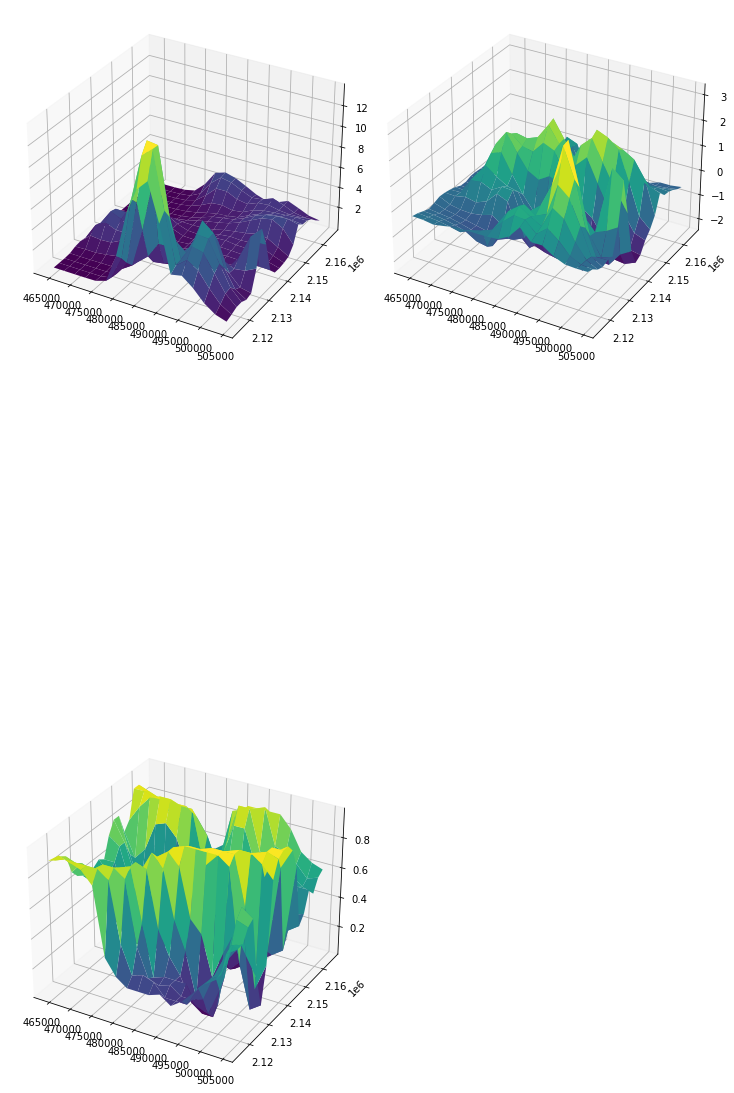

In [ ]:
fig = plt.figure(figsize=(10,20), constrained_layout=True)
ax = fig.add_subplot(221, projection='3d')
ax = ax.plot_surface(xx, yy, razones[0],cmap='viridis', edgecolor='none')
ax = fig.add_subplot(222, projection='3d')
ax = ax.plot_surface(xx, yy, intensidades[0],cmap='viridis', edgecolor='none')
ax = fig.add_subplot(223, projection='3d')
ax = ax.plot_surface(xx, yy, p_values[0],cmap='viridis', edgecolor='none')
# plt.tight_layout()

## p_value_maps

In [ ]:
# export
def p_value_maps(razones):
    """Regresa los mapas de significancia estadística para las razones."""
    p_values = []
    for r in razones:
        comp = [b >= r for b in razones]
        comp = np.sum(comp, axis=0)
        p = comp / (len(razones) + 1)
        p_values.append(p)
    return p_values

In [ ]:
significancias = p_value_maps(razones)